In [1]:
import os
import torch
import argparse
import sys
sys.path.append("/lid/home/saydalie/multimodal_cot")
sys.path.append("/lid/home/saydalie/multimodal_cot/anole")

from PIL import Image
from anole.chameleon.inference.chameleon import ChameleonInferenceModel, Options
from anole.constants import (
    MODEL_7B_PATH,
    TOKENIZER_TEXT_PATH,
    TOKENIZER_IMAGE_CFG_PATH,
    TOKENIZER_IMAGE_PATH,
)
from typing import List, Tuple

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_token_sequence(
    tokens: torch.LongTensor,
    boi: int,
    eoi: int
) -> List[Tuple[str, torch.LongTensor]]:
    """
    Split a sequence of tokens into text and image segments.
    
    Args:
        tokens (torch.LongTensor): The token sequence.
        boi (int): Begin of image token.
        eoi (int): End of image token.
    
    Returns:
        List[Tuple[str, torch.LongTensor]]: List of tuples indicating segment type and tokens.
    """
    batch_size, _ = tokens.shape
    assert batch_size == 1, "Batch size must be 1"
    
    device = tokens.device
    tokens = tokens[0]  # remove batch dimension
    tokens = tokens.to(device)
    segments = []
    current_segment = []
    in_image_seg = False

    for token in tokens:
        if token == boi:
            # if entering an image segment, save the current text segment (if any)
            if current_segment:
                segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
                current_segment = []
            in_image_seg = True
        elif token == eoi and in_image_seg:
            # if exiting an image segment, save the current image segment
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
            current_segment = []
            in_image_seg = False
        else:
            current_segment.append(token)
    # save any remaining tokens
    if current_segment:
        if in_image_seg:
            segments.append(("image_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
        else:
            segments.append(("text_seg", torch.tensor(current_segment, dtype=tokens.dtype, device=device).reshape(1, -1)))
    return segments

In [3]:
# Load Chameleon model
model = ChameleonInferenceModel(
    MODEL_7B_PATH.as_posix(),
    TOKENIZER_TEXT_PATH.as_posix(),
    TOKENIZER_IMAGE_CFG_PATH.as_posix(),
    TOKENIZER_IMAGE_PATH.as_posix(),
)
# Print model configuration
print(f"Model path: {MODEL_7B_PATH}")
print(f"Text tokenizer path: {TOKENIZER_TEXT_PATH}")
print(f"Image tokenizer config path: {TOKENIZER_IMAGE_CFG_PATH}")
print(f"Image tokenizer path: {TOKENIZER_IMAGE_PATH}")

VQModel loaded from /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.ckpt
Model path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/models/7b
Text tokenizer path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/text_tokenizer.json
Image tokenizer config path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.yaml
Image tokenizer path: /lid/home/saydalie/multimodal_cot/Anole-7b-v0.1/tokenizer/vqgan.ckpt


In [7]:
output_data = model.sft_puzzle_tokenization(
    data_dir = "/lid/home/saydalie/multimodal_cot/LLM-PuzzleTest/PuzzleVQA/data/train/",
    pattern_name = 'color_grid'
)
print(output_data[0]['input_text'])

Tokenize dataset: 10it [00:01,  6.42it/s]

# Question:
<img>What is the color of the missing part denoted with a question mark?

# Options:
(A) green
(B) red
(C) orange
(D) yellow

# Pattern
There are circles with different colors arranged with a grid formation in the image. The colors in the first row are ['red', '?', 'red'], the colors in the second row are ['orange', 'blue', 'orange'], and the colors in the third row are ['red', 'orange', 'red']. We observe that the circles at the corners are red, while the circles directly adjacent to the center are orange. Only the center circle is blue. Hence, the pattern is that the circles alternate in color depending on if they are at the corner or adjacent to the center.

# Option A
Replacing '?' with green: <img>
Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it does not fit the observed pattern. green is unlikely to be the correct answer.

# Option B
Replacing '?' with red: <img>
Reasoning: Comparing the colors of the circles at the corners

In [8]:
output_ids = torch.tensor([output_data[0]['input_text_ids']]).to('cuda')

In [9]:
boi, eoi = model.vocab.begin_image, model.vocab.end_image
segments = split_token_sequence(output_ids, boi, eoi)

for seg_type, seg_tokens in segments:
    print(seg_type, ':', len(seg_tokens[0]))

text_seg : 4
image_seg : 1024
text_seg : 203
image_seg : 1024
text_seg : 54
image_seg : 1024
text_seg : 54
image_seg : 1024
text_seg : 54
image_seg : 1024
text_seg : 121


# Question:



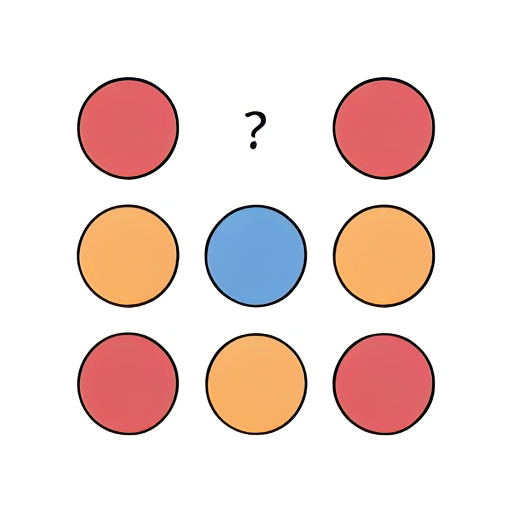

What is the color of the missing part denoted with a question mark?

# Options:
(A) green
(B) red
(C) orange
(D) yellow

# Pattern
There are circles with different colors arranged with a grid formation in the image. The colors in the first row are ['red', '?', 'red'], the colors in the second row are ['orange', 'blue', 'orange'], and the colors in the third row are ['red', 'orange', 'red']. We observe that the circles at the corners are red, while the circles directly adjacent to the center are orange. Only the center circle is blue. Hence, the pattern is that the circles alternate in color depending on if they are at the corner or adjacent to the center.

# Option A
Replacing '?' with green: 


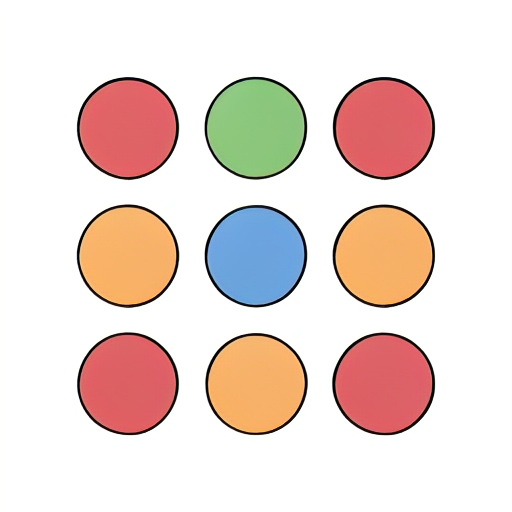


Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it does not fit the observed pattern. green is unlikely to be the correct answer.

# Option B
Replacing '?' with red: 


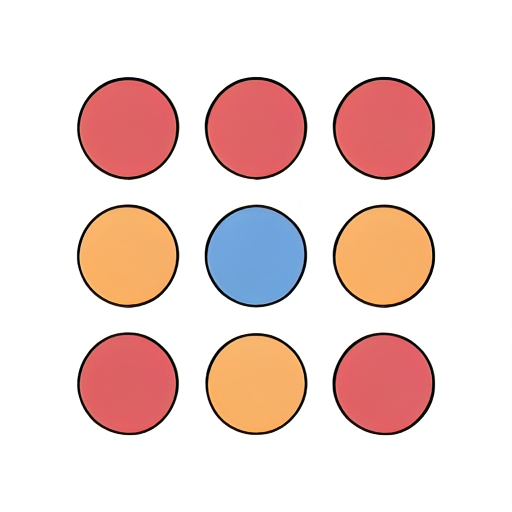


Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it does not fit the observed pattern. red is unlikely to be the correct answer.

# Option C
Replacing '?' with orange: 


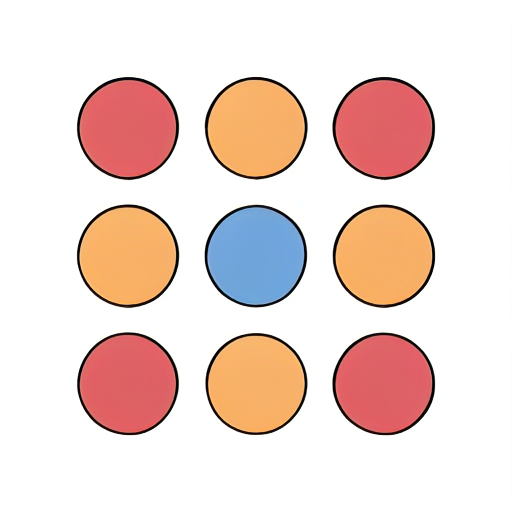


Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it matches well the observed pattern. orange is a strong candidate for the correct answer.

# Option D
Replacing '?' with yellow: 


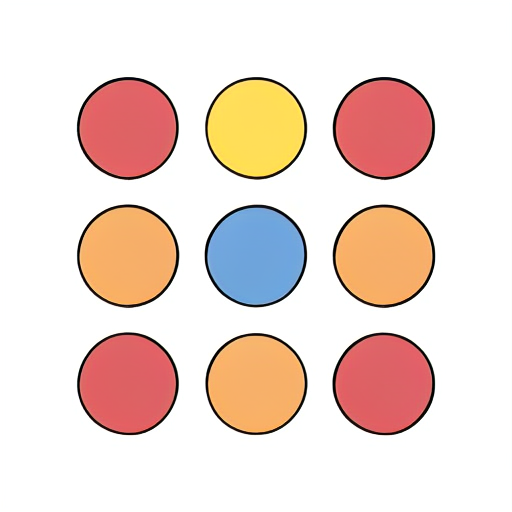


Reasoning: Comparing the colors of the circles at the corners and adjacent to the center, it does not fit the observed pattern. yellow is unlikely to be the correct answer.

# Final Answer
Based on the reasoning process, the best fit for the missing circle is orange. The pattern that the circles alternate in color depending on if they are at the corner or adjacent to the center holds consistently when we replace '?' with orange. Therefore, among (A) (B) (C) (D), the answer is: (C).


In [10]:
# decode
for seg_id, (seg_type, seg_tokens) in enumerate(segments):
    if seg_type == "image_seg":
        assert seg_tokens.shape[1] == 1024
        img: Image = model.decode_image(seg_tokens)[0]
        img.show()
    else:
        assert seg_type == "text_seg"
        decoded_text = model.decode_text(seg_tokens)[0]
        print(decoded_text)